In [1]:
import os
import time
import shutil
import pathlib
import itertools
import random
# import data handling tools
import tensorflow as tf


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg                           # Image loading and manipulation library
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam              # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau ,LambdaCallback      # Early stopping callback for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization        # Various types of layers for building neural networks
from tensorflow.keras.applications import  EfficientNetB0, InceptionV3, Xception, ResNet50, VGG16
from sklearn.utils.class_weight import compute_class_weight


In [3]:
image_size = 256
batch_size = 32
channels = 3

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset1/splitnew/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset1/splitnew/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset1/splitnew/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 14000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [5]:
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']


In [6]:
# Load the EfficientNetB0 model with pre-trained ImageNet weights, without the top layer
image_size = 256  # or the size you've used
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Fine-tune some top layers of the base model
for layer in base_model1.layers[-20:]:  # Unfreeze the last 20 layers for fine-tuning
    layer.trainable = True

# Add custom layers on top of the base model
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x1)  # L2 regularization
x1 = Dropout(0.5)(x1)  # Dropout for regularization


# Determine the number of classes from the original training dataset
num_classes1 = len(next(os.walk('/content/drive/MyDrive/dataset1/splitnew/train'))[1])
predictions1 = Dense(num_classes1, activation='softmax')(x1)

# Define the model
EfficientNetb0_model1 = Model(inputs=base_model1.input, outputs=predictions1)

# Compile the model with a lower learning rate
EfficientNetb0_model1.compile(optimizer=Adam(learning_rate=1e-5),  # Reduced learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks with increased patience and learning rate scheduling
callbacks1 = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('efficientnetb0_final_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),  # Reduce learning rate on plateau
    LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}: Accuracy: {logs['accuracy']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}"))
]



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Train the model1
history1 = EfficientNetb0_model1.fit(
    train_data,
    epochs=25,  # Number of epochs
    validation_data=val_data,
    callbacks=callbacks1
)

# Save the final model in both .keras and .h5 formats
EfficientNetb0_model1.save('/content/drive/MyDrive/EFFI_NET_model.keras')
EfficientNetb0_model1.save('/content/drive/MyDrive/EFFI_NET_model.h5')

print("Improved EfficientNet model has been trained and saved.")

import pickle

# Save training history
with open('/content/drive/MyDrive/EFFI_NET_model_history1.pkl', 'wb') as file_pi:
    pickle.dump(history1.history, file_pi)

print("Training history for Efficientnetb0_final_model has been saved.")

Epoch 1/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2719 - loss: 3.2353Epoch 1: Accuracy: 0.4418, Validation Accuracy: 0.1003
438/438 ━━━━━━━━━━━━━━━━━━━━ 2856s 6s/step - accuracy: 0.2723 - loss: 3.2347 - val_accuracy: 0.1003 - val_loss: 3.4537 - learning_rate: 1.0000e-05
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7738 - loss: 2.1022Epoch 2: Accuracy: 0.8098, Validation Accuracy: 0.8153
438/438 ━━━━━━━━━━━━━━━━━━━━ 115s 191ms/step - accuracy: 0.7739 - loss: 2.1018 - val_accuracy: 0.8153 - val_loss: 1.7557 - learning_rate: 1.0000e-05
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8832 - loss: 1.5527Epoch 3: Accuracy: 0.8965, Validation Accuracy: 0.9393
438/438 ━━━━━━━━━━━━━━━━━━━━ 153s 216ms/step - accuracy: 0.8833 - loss: 1.5525 - val_accuracy: 0.9393 - val_loss: 1.3129 - learning_rate: 1.0000e-05
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9192 - loss: 1.3779Epoch 4: Accuracy: 0.9293, Validation Accurac

Improved EfficientNet model has been trained and saved.
Training history for Efficientnetb0_final_model has been saved.


In [8]:
# Evaluate EfficientNetb0 model on the test set
EfficientNetb0_model1_test_loss, EfficientNetb0_model1_test_accuracy = EfficientNetb0_model1.evaluate(test_data)
print(f"EfficientNetb0 Test Accuracy: {EfficientNetb0_model1_test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 436s 5s/step - accuracy: 0.9945 - loss: 0.5358
Inceptionv3 Test Accuracy: 99.33%


Found 3000 images belonging to 10 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

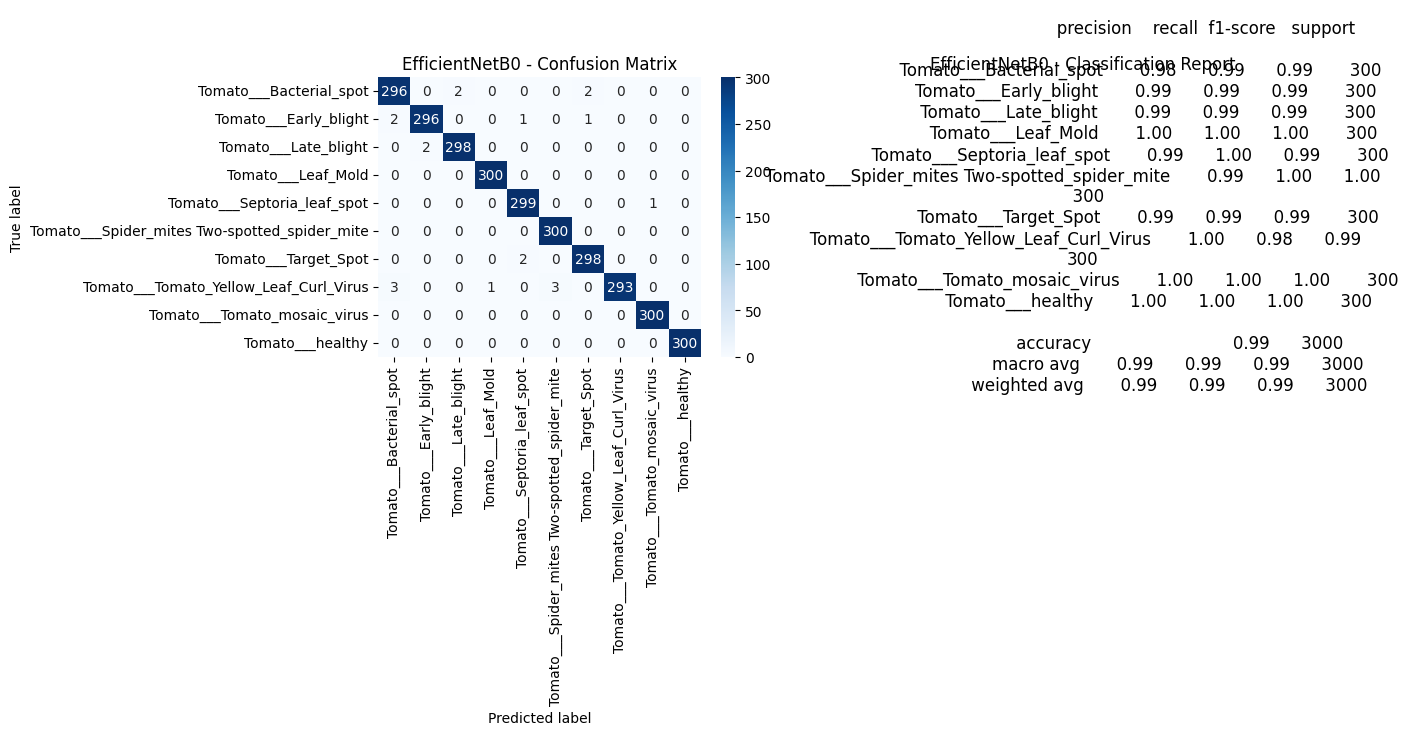

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Function to plot confusion matrix and classification report
def plot_confusion_matrix_and_report(cm, report, classes, title, color_palette):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_palette, xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title(f'{title} - Confusion Matrix')
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # Plot classification report
    ax2.text(0.5, 0.5, report, ha='center', va='center', fontsize=12, wrap=True)
    ax2.set_title(f'{title} - Classification Report')
    ax2.axis('off')  # Hide the axes for the report

    plt.tight_layout()
    plt.show()

# Define the path to your test data
test_data_dir = '/content/drive/MyDrive/dataset1/splitnew/test'
# Create an ImageDataGenerator for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate over the test data using flow_from_directory
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep data in order for accurate evaluation
)

# Define your class names
class_names =['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']
  # Replace with your actual class names if different

# Load the EfficientNetB0 model
EfficientNetb0_model_h5 = load_model('/content/drive/MyDrive/EFFI_NET_model.h5')

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Evaluate the model on the test data and generate predictions
for images, labels in test_data:
    # Predict the labels
    predictions = EfficientNetb0_model_h5.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Get the true labels
    true_labels = np.argmax(labels, axis=1)

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

    # Break the loop once all test data has been processed
    if len(y_true) >= test_data.samples:
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix for EfficientNetB0 model
cm = confusion_matrix(y_true, y_pred)

# Generate classification report for EfficientNetB0 model
report = classification_report(y_true, y_pred, target_names=class_names)

# Plot confusion matrix and classification report
plot_confusion_matrix_and_report(cm, report, classes=class_names, title='EfficientNetB0', color_palette='Blues')


Found 3000 images belonging to 10 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

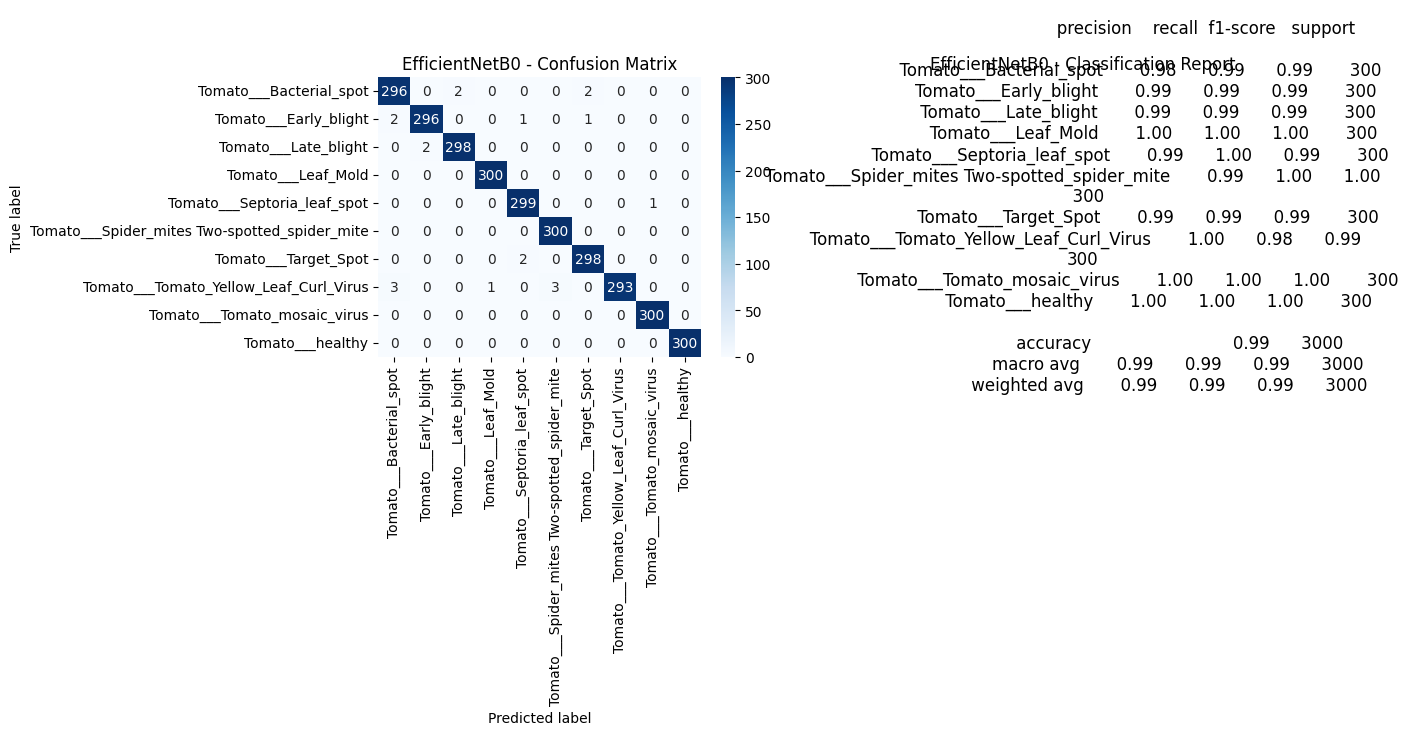

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Function to plot confusion matrix and classification report
def plot_confusion_matrix_and_report(cm, report, classes, title, color_palette):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_palette, xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title(f'{title} - Confusion Matrix')
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # Plot classification report
    ax2.text(0.5, 0.5, report, ha='center', va='center', fontsize=12, wrap=True)
    ax2.set_title(f'{title} - Classification Report')
    ax2.axis('off')  # Hide the axes for the report

    plt.tight_layout()
    plt.show()

# Define the path to your test data
test_data_dir = '/content/drive/MyDrive/dataset1/splitnew/test'
# Create an ImageDataGenerator for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate over the test data using flow_from_directory
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep data in order for accurate evaluation
)

# Define your class names
class_names =['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']
  # Replace with your actual class names if different

# Load the EfficientNetB0 model
EfficientNetb0_model_h5 = load_model('/content/drive/MyDrive/EFFI_NET_model.h5')

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Evaluate the model on the test data and generate predictions
for images, labels in test_data:
    # Predict the labels
    predictions = EfficientNetb0_model_h5.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Get the true labels
    true_labels = np.argmax(labels, axis=1)

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

    # Break the loop once all test data has been processed
    if len(y_true) >= test_data.samples:
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix for EfficientNetB0 model
cm = confusion_matrix(y_true, y_pred)

# Generate classification report for EfficientNetB0 model
report = classification_report(y_true, y_pred, target_names=class_names)

# Plot confusion matrix and classification report
plot_confusion_matrix_and_report(cm, report, classes=class_names, title='EfficientNetB0', color_palette='Blues')


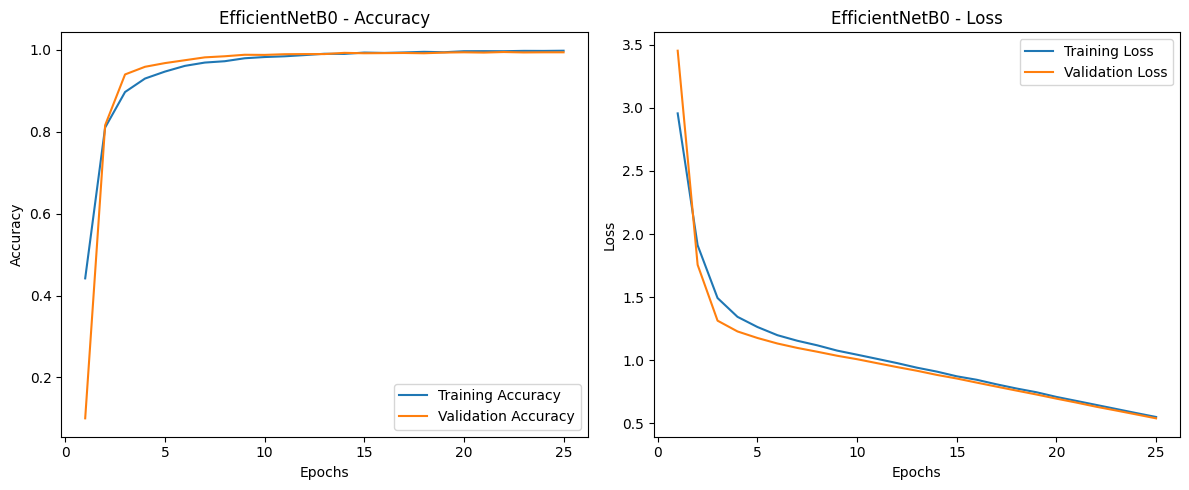

In [15]:
import matplotlib.pyplot as plt
import pickle

# Reload training history for EfficientNetB0
with open('/content/drive/MyDrive/EFFI_NET_model_history1.pkl', 'rb') as file:
    history1 = pickle.load(file)

def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax[0].plot(epochs, acc, label='Training Accuracy')
    ax[0].plot(epochs, val_acc, label='Validation Accuracy')
    ax[0].set_title(f'{title} - Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(epochs, loss, label='Training Loss')
    ax[1].plot(epochs, val_loss, label='Validation Loss')
    ax[1].set_title(f'{title} - Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Plot training history for EfficientNetB0 model only
plot_training_history(history1, "EfficientNetB0")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


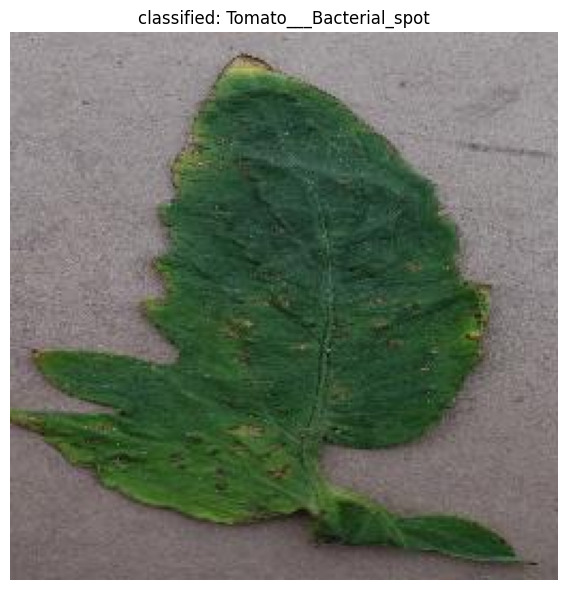

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Bacterial_spot/05530c50-5cb9-484f-91d0-82c9df7689d5___GCREC_Bact.Sp 6051.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


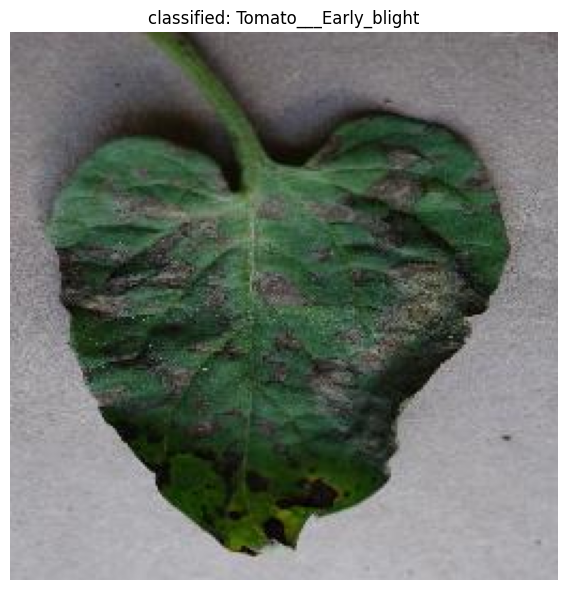

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Early_blight/07409e2c-a730-4b11-b25e-31025bd63a91___RS_Erly.B 9578_flipTB.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


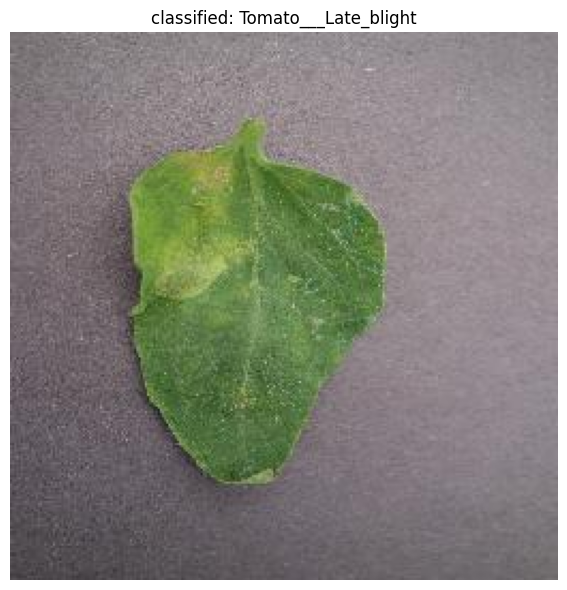

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Late_blight/023315df-8824-4760-9480-4dca3a023931___GHLB2 Leaf 8719.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


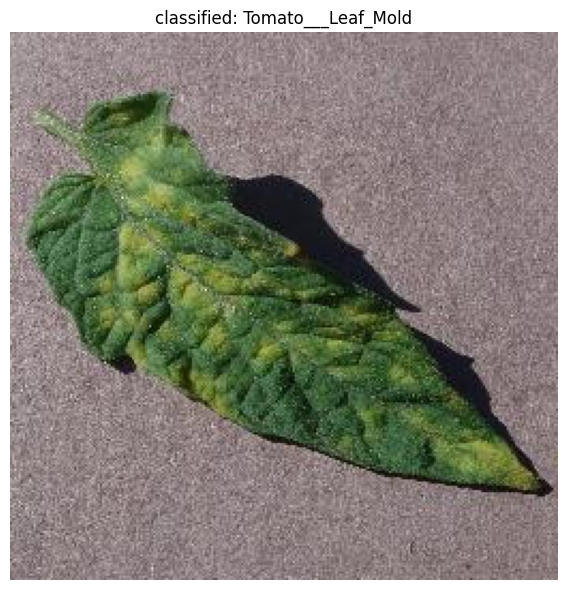

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Leaf_Mold/0462054e-f0aa-41a7-a9cc-95d0784b9767___Crnl_L.Mold 6547_flipTB.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


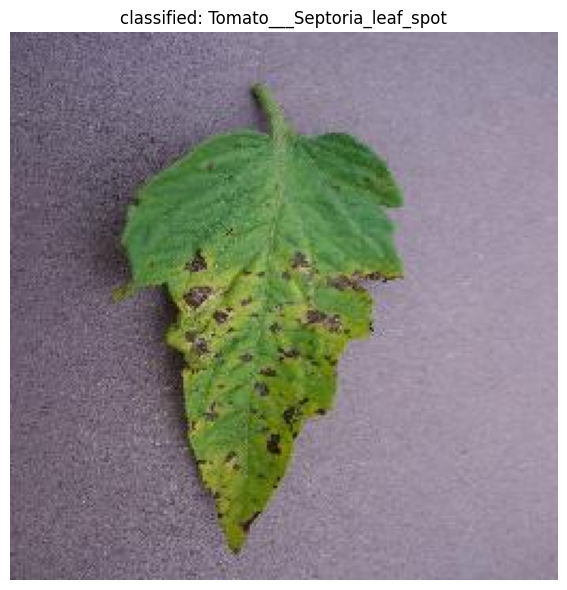

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Septoria_leaf_spot/01f54ad9-9c03-4ffd-86f4-829fc2939120___Matt.S_CG 0702_flipTB.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


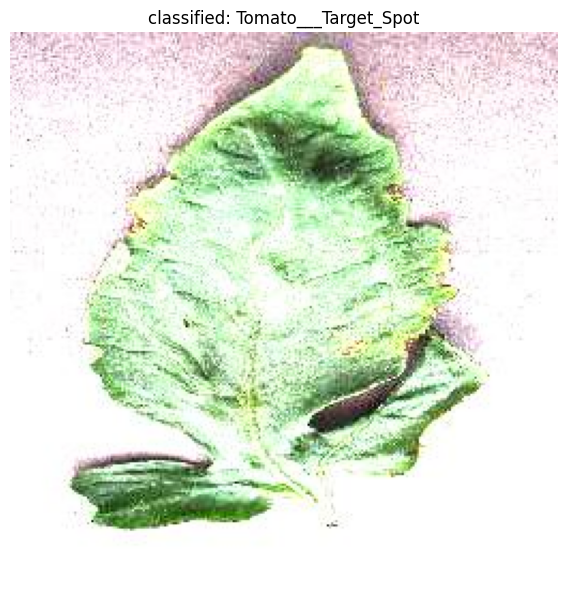

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Target_Spot/03e3b044-d81f-49ca-a4d3-c6f7173b55a9___Com.G_TgS_FL 9921_newPixel25.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


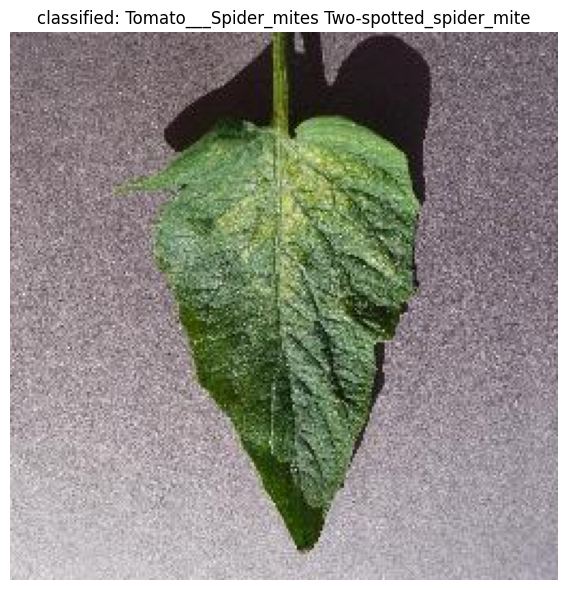

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Spider_mites Two-spotted_spider_mite/03dc4d71-45b6-4845-9f66-3b7aae5375e1___Com.G_SpM_FL 1193_flipTB.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


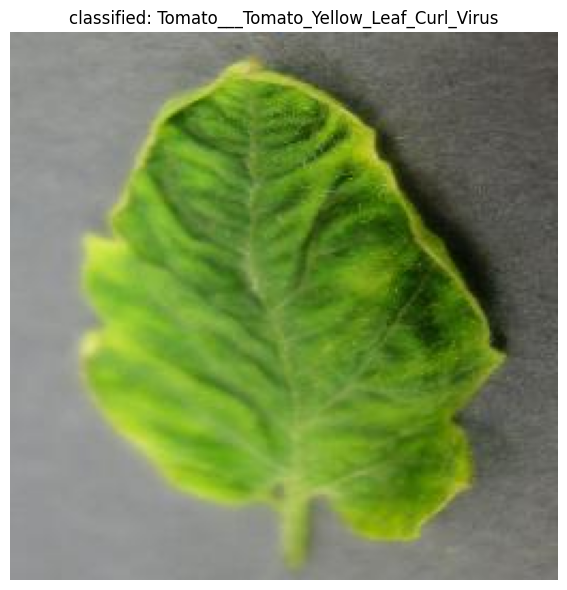

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/11796227-f10e-4502-a849-ddff117a083c___UF.GRC_YLCV_Lab 03130.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


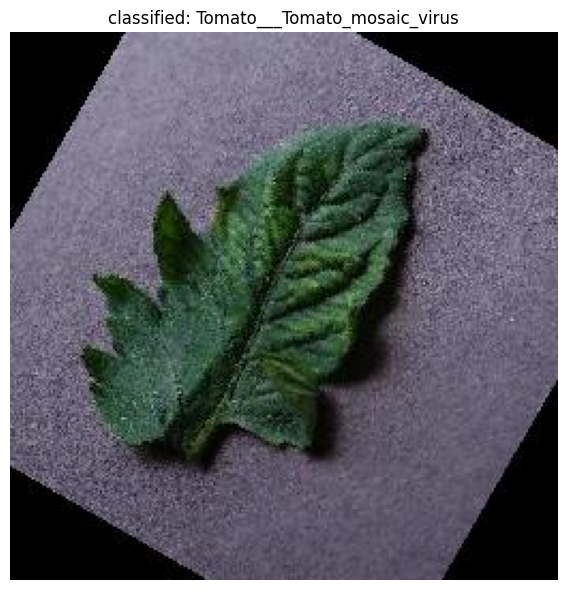

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___Tomato_mosaic_virus/0a91f50b-1263-4b2c-a8c1-f2a6025b82f3___PSU_CG 2136_new30degFlipLR.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


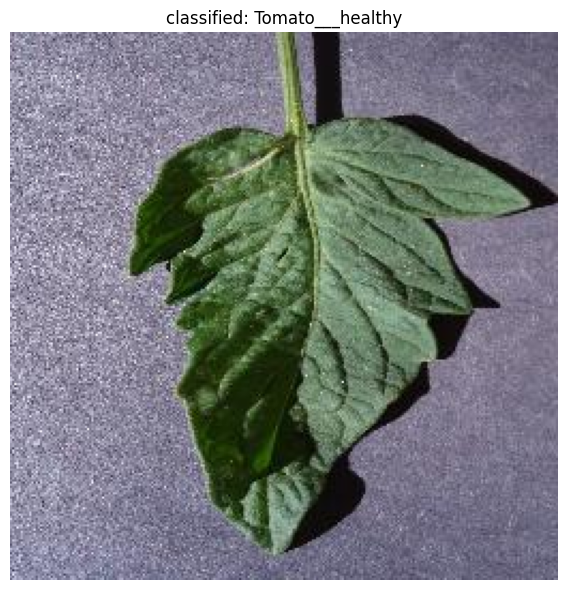

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/splitnew/test/Tomato___healthy/01c1da17-8d9f-4d69-8a1e-58d37453d3c3___RS_HL 9641_flipTB.JPG'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


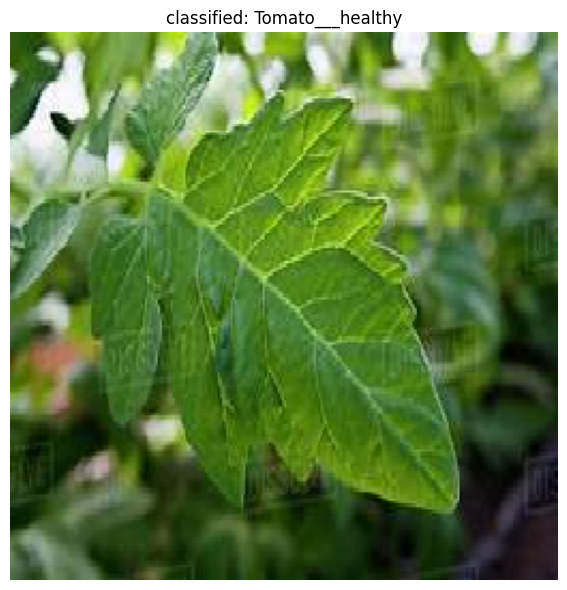

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/new_images/Tomato___healthy.jpeg'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


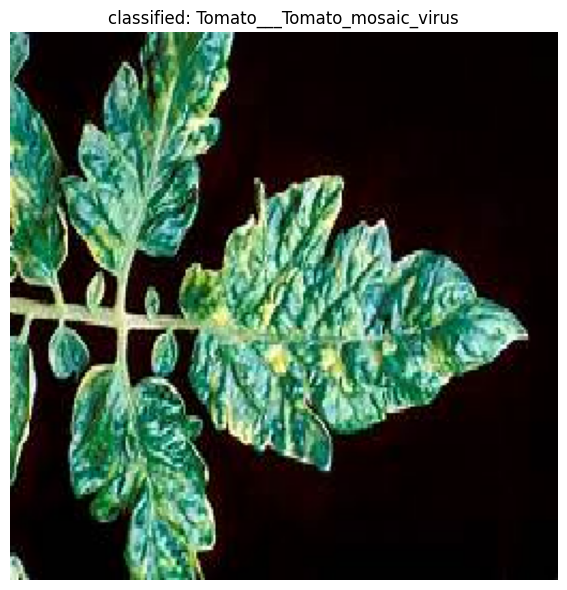

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to make predictions on a single image and return class label
def make_predictions(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(256, 256))  # Load and resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)  # Get the predicted class index
    predicted_label = class_names[predicted_class[0]]  # Get the label from the class_names list

    return predicted_label, img

# Path to one test image (adjust the path to your image)
img_path = '/content/drive/MyDrive/dataset1/new_images/Tomato___Tomato_mosaic_virus.jpeg'

# Class names for marine species classification
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# Make predictions on the single image using EfficientNetB0
prediction, img = make_predictions(EfficientNetb0_model_h5, img_path, class_names)

# Plot the image and prediction
plt.figure(figsize=(6, 6))

# Plot the original image
plt.imshow(img)
plt.axis('off')
plt.title(f"classified: {prediction}")

# Show the plot
plt.tight_layout()
plt.show()
